## Summary

Notre carte « probabilité cobalt » repose sur une idée simple : plus un endroit se situe près à la fois de roches ultramafiques/serpentinites et d’intrusions granodioritiques, plus il est intéressant du point de vue du cobalt. Concrètement, nous partons d’une carte géologique existante et identifions, dans les descriptions d’unités, les termes qui signalent ces deux familles de roches (par exemple : ultramafique, serpentinite, dunite, péridotite, d’un côté ; granodiorite de l’autre). Toutes les unités reconnues sont ensuite regroupées en deux ensembles continus : l’ensemble « ultramafique » et l’ensemble « granodioritique ». Sur l’emprise d’étude, nous posons une grille régulière (maillage en mètres) et, pour chaque cellule, nous mesurons la distance la plus courte à chacun des deux ensembles. Ces deux distances sont converties en deux « proximities » comprises entre 0 et 1 : au contact, la valeur est maximale ; au-delà d’une portée choisie (10 km dans notre cas), elle devient zéro. 

Le score final est le produit de ces deux proximities : il est élevé uniquement là où l’on est simultanément proche des ultramafiques/serpentinites et des granodiorites, ce qui reflète l’intuition géologique recherchée. Le résultat est livré sous forme d’un GeoTIFF utilisable en SIG et d’un PNG lisible, avec la possibilité d’extraire des « hotspots » pour guider la reconnaissance de terrain. 

Cette approche est transparente, reproductible et paramétrable (taille de grille, portée de proximité, vocabulaire de détection). Elle constitue un indicateur de contexte robuste pour prioriser les secteurs où concentrer l’attention et les moyens.

## Importing Libraries and Dependencies


In [2]:
import re
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Configuration of the Tool

This section defines all the input paths, output files, and key parameters 
used in the heatmap generation process.  
- *Input / Output paths*: location of the geological data (GeoPackage) and 
  the output raster/image files.  
- *Lithology patterns*: regex patterns used to detect ultramafic/serpentinite 
  (Group A) and granodiorite (Group B) units.  
- *Resolution and decay distance*: control the grid size (detail level) and 
  the spatial influence of rocks.  
- *CRS*: projection system in meters.  
- *Masking and text columns*: optional land mask and fields scanned for lithology keywords.  

In [3]:
# === CONFIG: edit these only (keep distances in METERS) =======================

INPUT      = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\Kobold_Takehome_Assignment_Data\BedrockP.gpkg" # Bedrock polygons (GeoPackage)
OUT_TIF    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.tif"  # eoTIFF output – GIS-ready raster (score 0–1).
OUT_PNG    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.png"  # PNG preview – quick map image

# --- Lithology patterns -----------------------------------------------
PATTERN_A  = r"ultramafic|serpentin\w*|dunite|harzburgite|peridotite|komatiite|ophiolite"  # ultramafiques ≈ serpentinite
# Group A: ultramafic/serpentinite keywords (‘|’ = OR, ‘\w*’ = any ending).

PATTERN_B  = r"granodior\w*"  # granodiorite / granodioritic
# Group B: granodiorite keywords (matches “granodiorite/granodioritic”).

RES_M      = 250        # Grid cell size in meters for the heat map. Smaller cell => finer detail, but heavier computation and larger files. 
DECAY_M    = 10000      # DECAY_M defines how far a rock influences the score: value 1 at contact, decreasing gradually to 0 at DECAY_M. 
#Larger values create a more regional effect, smaller values a more local effect.

CRS_EPSG   = 26910      # EPSG code of a PROJECTED CRS in meters.

LAND_PATH  = None  # Optional polygon layer representing land (to mask out ocean areas). Leave as None to skip masking.

# Columns scanned for Group A patterns (broader search). Use fields that contain
# lithology / formation / unit descriptions.
TEXT_COLS_ALL = ("rock_class","rock_type","unit_desc","strat_name","gp_suite","fm_lithodm","mem_phase")
TEXT_COLS_B   = ("rock_class","rock_type","unit_desc","strat_name") # Columns scanned for Group B (granodiorite). Often these four are sufficient.

NODATA_VAL = -9999.0

## Utility Functions (Text Normalization & Proximity Scoring)

This section defines helper functions used throughout the script:

- **`proximity_score(d1, d2, D)`**:  
  Computes a linear proximity score between two lithology groups (A and B).  
  The score is highest (1.0) when the point is in direct contact with both groups,  
  and decreases linearly with distance until reaching 0 at `D`.

- **`_normtxt(x)`**:  
  Normalizes text fields to improve regex matching (lowercasing, removing special characters, collapsing spaces).

- **`_tag_matches(df, patterns, cols)`**:  
  Searches row by row in selected text columns of a GeoDataFrame to detect whether  
  lithology descriptions match specified regex patterns (e.g., ultramafic, serpentinite, granodiorite).

In [4]:

# ----------- Tools -----------
def proximity_score(d1: float, d2: float, D: float) -> float:
    """
    Linear proximity score to two targets.
    - d1, d2: distances to rock groups A and B (meters)
    - D: decay distance (meters). At D, contribution falls to 0.
    Formula: max(0, 1 - d1/D) * max(0, 1 - d2/D)
    -> High only if the point is close to BOTH groups.
    """
    
    if D <= 0:
        raise ValueError("DECAY_M doit être > 0.")
    s1 = max(0.0, 1.0 - d1 / D)
    s2 = max(0.0, 1.0 - d2 / D)
    return s1 * s2

def _normtxt(x):
    """
    Normalize text for robust regex matching:
    - None → ""
    - lowercases
    - keeps only [a-z0-9 -_/.] and spaces
    - collapses multiple spaces
    """
    if x is None:
        return ""
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s\-_/\.]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def _tag_matches(df: gpd.GeoDataFrame, patterns: str, cols):
    """
    Row-wise regex search over selected text columns.
    - df: GeoDataFrame with lithology/unit text fields
    - patterns: compiled regex string (e.g., 'ultramafic|serpentin\\w*|...')
    - cols: iterable of column names to scan
    Returns: Boolean Series (True where any column matches).
    """
    rx = re.compile(patterns)
    def rowok(row):
        blob = " ".join(_normtxt(row.get(c, "")) for c in cols)
        return bool(rx.search(blob))
    return df.apply(rowok, axis=1)


* proximity_score(d1, d2, D) → float
Returns a score in [0, 1]: max(0, 1 - d1/D) * max(0, 1 - d2/D).
High only when the point is close to both rock groups (A and B). D is the decay distance (meters).

* _normtxt(x) → str
Normalizes text for robust regex matching: lowercases, removes non [a-z0-9 -_/.], collapses spaces.

* _tag_matches(df, patterns, cols) → Series[bool]
For each row, concatenates normalized values of cols and searches the regex patterns.
Returns a boolean mask (True where the row contains a match).

## Main Function — Heatmap Generation (`make_heatmap`)

Generates a proximity-based heatmap (score 0–1) highlighting areas close to *both* lithology groups:
ultramafic/serpentinite (Group A) and granodiorite (Group B). The score decreases linearly with distance
and reaches 0 at `decay_m`. Outputs a GIS-ready *GeoTIFF* and a quick-view *PNG*.

**Inputs & key params**
- `input_path`: GeoPackage of bedrock polygons (text fields scanned for regex matches).
- `pattern_a`, `pattern_b`: regex patterns for Groups A and B.
- `res_m`: grid cell size (m). Smaller → finer detail, heavier compute.
- `decay_m`: influence radius (m). Larger → more regional halos.
- `crs_epsg`: projected CRS in meters (data are reprojected if needed).
- `land_path` (optional): polygon mask to keep land only.
- `text_cols_all`, `text_cols_b`: columns scanned for A/B patterns.
- `out_tif`, `out_png`: output file paths.
- `nodata_val`: raster NoData value.

**What the function does (steps)**
1. *Read & reproject* data to `crs_epsg`; fix invalid geometries.
2. *Tag features* matching A/B regex across selected text columns.
3. *Union* geometries per group to speed up distance queries.
4. *Build grid* from dataset bounds at resolution `res_m`.
5. *Compute distances* for each cell to `union_a` and `union_b`; compute proximity score via `proximity_score`.
6. *Optional land mask*: rasterize `land_path` and set non-land cells to NaN.
7. *Write GeoTIFF* (single band, 0–1, with `nodata_val` for NaNs).
8. *Export PNG* with correct orientation and thin geology outlines.
9. *Return summary* (grid size, min/max score, CRS, outputs).

**Assumptions / safeguards**
- Fails fast if no features match `pattern_a` or `pattern_b`.
- Requires a *projected* CRS in meters (distance-based logic).
- Handles minor geometry issues with `buffer(0)`.

**Typical usage**
Provide your input paths, regex patterns, resolution, and decay distance in the config section, then call `make_heatmap(...)`.


In [5]:


# -----------  Main Function----------
def make_heatmap(
    input_path: str,
    out_tif: str,
    out_png: str,
    pattern_a: str,
    pattern_b: str,
    res_m: int = 250,
    decay_m: int = 10000,
    crs_epsg: int = 26910,
    land_path: str = None,
    text_cols_all=TEXT_COLS_ALL,
    text_cols_b=TEXT_COLS_B,
    nodata_val: float = -9999.0,
):
    # 1) Data Reading & Reprojection
    gdf = gpd.read_file(input_path)
    if gdf.empty:
        raise RuntimeError("The input file is empty or unreadable")
    if gdf.crs is None or gdf.crs.to_epsg() != crs_epsg:
        gdf = gdf.to_crs(crs_epsg)

    # Fix invalid geometries only
    if not gdf.geometry.is_valid.all():
        bad = ~gdf.geometry.is_valid
        gdf.loc[bad, "geometry"] = gdf.loc[bad, "geometry"].buffer(0)

    # 2) Tags
    for c in text_cols_all:
        if c not in gdf.columns:
            gdf[c] = ""

    tags_a = _tag_matches(gdf, pattern_a, text_cols_all)
    tags_b = _tag_matches(gdf, pattern_b, text_cols_b)

    if not tags_a.any():
        raise RuntimeError("No objects match PATTERN_A. Adjust the pattern.")
    if not tags_b.any():
        raise RuntimeError("No objects match PATTERN_B. Adjust the pattern.")

    geom_a = gdf.loc[tags_a, "geometry"].buffer(0)
    geom_b = gdf.loc[tags_b, "geometry"].buffer(0)

    # 3) Unions
    union_a = unary_union(geom_a)
    union_b = unary_union(geom_b)

    # 4) Spatial grid or Fishnet grid
    minx, miny, maxx, maxy = gdf.total_bounds
    width  = int(np.ceil((maxx - minx) / res_m))
    height = int(np.ceil((maxy - miny) / res_m))
    transform = from_origin(minx, maxy, res_m, res_m)
    if width <= 0 or height <= 0:
        raise RuntimeError("Empty grid. Check the extent or resolution.")

    xs = minx + (np.arange(width) + 0.5) * res_m
    ys = maxy - (np.arange(height) + 0.5) * res_m  # Row 0 = top
    scores = np.zeros((height, width), dtype=np.float32)

    # 5) Distances computed row by row
    for j in range(height):
        y = ys[j]
        row_vals = np.empty(width, dtype=np.float32)
        for i, x in enumerate(xs):
            p = Point(float(x), float(y))
            du = p.distance(union_a)
            db = p.distance(union_b)
            row_vals[i] = proximity_score(du, db, decay_m)
        scores[j, :] = row_vals


    # 6) Writing data as a GeoTIFF
    outarr = np.where(np.isnan(scores), nodata_val, scores).astype(np.float32)
    with rasterio.open(
        out_tif, "w",
        driver="GTiff",
        height=height, width=width, count=1,
        dtype=outarr.dtype,
        crs=f"EPSG:{crs_epsg}",
        transform=transform,
        compress="lzw",
        nodata=nodata_val
    ) as dst:
        dst.write(outarr, 1)

    # 7) Export PNG with correct orientation
    fig, ax = plt.subplots(figsize=(8, 8))
    extent = (minx, maxx, miny, maxy)
    im = ax.imshow(scores, origin="upper", extent=extent)  # ligne 0 = top
    #im = ax.imshow(scores, origin="upper", extent=extent, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label="Score (0–1)")
    try:
        gdf.boundary.plot(ax=ax, linewidth=0.2, color="white")
    except Exception as e:
        print("Contours not displayed:", e)
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_aspect("equal")
    ax.set_title("Proximity score(AxB --- linear decay")
    ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.show()
    plt.close(fig)

    # 8) Summary
    return {
        "grid": (width, height),
        "resolution_m": res_m,
        "decay_m": decay_m,
        "crs": crs_epsg,
        "min_score": float(np.nanmin(scores)),
        "max_score": float(np.nanmax(scores)),
        "out_tif": out_tif,
        "out_png": out_png,
    }

## Extended Self-Test for `proximity_score`

This test block verifies the core behavior of the proximity scoring function.  
It checks expected values at key distances, symmetry between inputs, and proper cutoff beyond the decay distance.


In [6]:

def self_test():
    D = 10000.0
    
    # Basic cases
    assert proximity_score(0.0, 0.0, D) == 1.0, "Error: both zero distances should give 1.0"
    assert proximity_score(D, 0.0, D) == 0.0, "Error: at D from group A the score should be 0.0"
    assert proximity_score(0.0, D, D) == 0.0, "Error: at D from group B the score should be 0.0"
    
    # Midpoint distance
    mid = proximity_score(D/2, D/2, D)
    assert 0.24 < mid < 0.26, f"Error: expected ≈0.25 but got {mid}"
    
    # Symmetry (d1,d2) <-> (d2,d1)
    s1 = proximity_score(3000, 7000, D)
    s2 = proximity_score(7000, 3000, D)
    assert abs(s1 - s2) < 1e-12, "Error: function must be symmetric"
    
    # Out-of-range values (beyond D)
    assert proximity_score(2*D, 0, D) == 0.0, "Error: beyond D the score must be 0.0"
    assert proximity_score(0, 2*D, D) == 0.0, "Error: beyond D the score must be 0.0"
    
    print("Self-test OK")

In [7]:
self_test()

Self-test OK


## Direct Call — Running the Heatmap Generator  

This block executes the `make_heatmap()` function using the configuration defined earlier.  

It produces two outputs:  
- **GeoTIFF (`out_tif`)** → GIS-ready raster file with proximity scores (0–1).  
- **PNG (`out_png`)** → quick visualization of the heatmap with geology outlines.  

The function also returns a `summary` dictionary containing key metadata, including grid size, resolution, CRS, min/max scores, and output paths.  

#### Function Signature (key parameters)  
- **input_path** (*str*): Bedrock polygons (GeoPackage).  
- **out_tif, out_png** (*str*): Output file paths.  
- **pattern_a, pattern_b** (*str*): Regex patterns to tag Group A/B lithologies.  
- **res_m** (*int*): Grid resolution (meters).  
- **decay_m** (*int*): Distance (in meters) where the score drops to 0.  
- **crs_epsg** (*int*): Projected CRS in meters (e.g., UTM).  
- **land_path** (*str* | *None*): Optional land polygons to mask oceans.  
- **text_cols_all, text_cols_b**: Columns scanned for A/B patterns.  
- **nodata_val** (*float*): Fill value outside the valid area.  

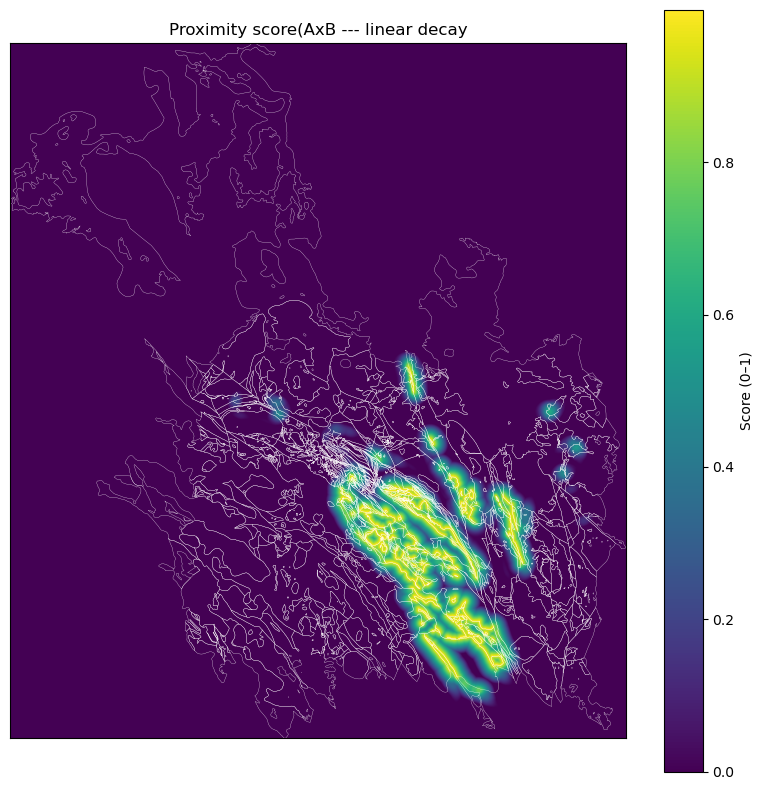

In [8]:
# ----------- APPEL DIRECT -----------
summary = make_heatmap(
    input_path=INPUT,
    out_tif=OUT_TIF,
    out_png=OUT_PNG,
    pattern_a=PATTERN_A,
    pattern_b=PATTERN_B,
    res_m=RES_M,
    decay_m=DECAY_M,
    crs_epsg=CRS_EPSG,
    land_path=LAND_PATH,
    text_cols_all=TEXT_COLS_ALL,
    text_cols_b=TEXT_COLS_B,
    nodata_val=NODATA_VAL
)

In [9]:
print(summary)

{'grid': (1617, 1824), 'resolution_m': 250, 'decay_m': 10000, 'crs': 26910, 'min_score': 0.0, 'max_score': 0.9999903440475464, 'out_tif': 'D:\\DS_kokold\\DS_Kobold_Takehome_Assignment_Data\\heatmap_cobalt.tif', 'out_png': 'D:\\DS_kokold\\DS_Kobold_Takehome_Assignment_Data\\heatmap_cobalt.png'}


## Summary of Heatmap Run  

This block converts the returned `summary` dictionary into a DataFrame for easier visualization.  
It shows key metadata such as grid dimensions, resolution, CRS, min/max scores, and output file paths.  

In [9]:
import pandas as pd
from IPython.display import display

summary_df = pd.DataFrame(list(summary.items()), columns=["Parameter", "Value"])
display(summary_df)


,Parameter,Value
0,grid,"(1617, 1824)"
1,resolution_m,250
2,decay_m,10000
3,crs,26910
4,min_score,0.0
5,max_score,0.99999
6,masked_ocean,False
7,out_tif,D:\DS_kokold\DS_Kobold_Takehome_Assignment_Dat...
8,out_png,D:\DS_kokold\DS_Kobold_Takehome_Assignment_Dat...


## Note on Method Choice: Why I Kept the Simple Per-Pixel Version (and What I’d Use in Production)

**TL;DR** — I intentionally used the *per-pixel, vector-distance* approach in this notebook because it is **didactic**: it exposes the core idea (distance to Group A and Group B → decay → combination) in a way that’s easy to read, reason about, and debug step-by-step.  
For a **production** pipeline on large areas, I would switch to a **rasterized Euclidean Distance Transform (EDT)** workflow, which is much faster and more scalable.

### Why the educational method here?
- **Transparency:** The loop shows exactly how a score at a cell is computed from distances to A/B.  
- **Concept first:** It makes the *geometry → distance → decay → aggregation* logic explicit.  
- **Ease of teaching & debugging:** Each step can be inspected (e.g., try a single row/col, print intermediate distances, change `decay_m` and observe effects).  
- **One-to-one with the formula:** With `α = β = 1`, the implementation mirrors the math:  
  \[
  \text{score} = \max(0,1-\tfrac{d_A}{D}) \times \max(0,1-\tfrac{d_B}{D})
  \]

### What I would use in production (faster, scalable)
A **raster-first** pipeline using the **Euclidean Distance Transform (EDT)**:

1. **Regex tagging (A/B)** on attributes (vector).  
2. **Rasterize** groups A and B to a grid (`res_m`) → binary masks (1=inside group, 0=elsewhere).  
3. **EDT** on each mask to get **distance-to-group** per cell (in pixels), then convert to meters (`distance_px * res_m`).  
4. **Apply decay** (e.g., linear: `f = clip(1 - d/D, 0, 1)`).  
5. **Aggregate** (e.g., product with optional weights `α`, `β`).  
6. **Export** GeoTIFF + PNG.

**Why this is better for large jobs**
- **Speed:** No Python loops over pixels; EDT + NumPy ops run in compiled code (C).  
- **Scalability:** Handles large rasters gracefully; performance is typically orders of magnitude faster.  
- **Stability & reproducibility:** Entirely array-based; fewer geometry edge-cases after rasterization.

### Trade-offs (so you know what you’re choosing)
- **Rasterization vs. vector exactness:** EDT works on the raster grid; the effective accuracy depends on `res_m`. Finer resolution → more precise (but larger data).  
- **Memory:** Very fine grids increase memory usage; tune `res_m` accordingly.  
- **Behavior at boundaries:** Unioning geometries before rasterization reduces slivers; `all_touched=False` keeps masks conservative.  
- **CRS:** A **projected CRS in meters** is still mandatory (distance-based logic).

### When to choose which
- **Teaching, notebooks, small AOIs:** Per-pixel vector distances are fine and very **illustrative**.  
- **Batch runs, country/region scale, iterations:** Prefer **raster + EDT** for **speed** and **robustness**.

### Extensions I would enable in the EDT path
- **Alternative decays:** Gaussian/RBF (`exp(-(d/σ)^2)`) for smoother halos.  
- **Alternative aggregations:** Harmonic mean or soft-min if you want different interplay between A and B.  
- **Weights (`α`, `β`):** Emphasize one group if geologically more diagnostic.  
- **Optional masks:** Land/permit boundaries to restrict output area.

**Bottom line:** I kept the “old” method here because it is **more educational** and matches the formula line-by-line. If this were a **production tool**, I’d switch to the **EDT** workflow for **performance** and **scalability**, while preserving the same geologic logic and outputs (GeoTIFF + PNG + summary).
